# An example of using EASYMORE with source netCDF files in irregualr shape 
## Remapping of SCDNA to subbasins of South Saskatchewan River at Medicine Hat, Alberta, Canada.

In [1]:
# download SCDNA data and convert it to xarray-based format

import xarray as xr
import urllib.request
import numpy as np
import pandas as pd
import os
from datetime import datetime
import time

pwd = '/Users/shg096/Desktop/SCDNA/' # folder where downloaded SCDNA is save should be ending with '/'
fname = 'SCDNA_v1.1.nc'

def download_process_SCDNA(pwd, filename):
    
    if not os.path.isdir(pwd):
        os.mkdir(pwd)
    
    # remove existing file is exists
    outfile = pwd+filename
    if os.path.isfile(outfile):
        print('It seems the file exists; perhaps perviously downloaded; will skip downloading')
    else:
        # download the file
        print('Downloading SCDNA; this may take a while ...')
        print('Downloading starts at: ', datetime.now())
        url = 'http://zenodo.org/record/3953310/files/SCDNA_v1.1.nc4?download=1'
        urllib.request.urlretrieve(url, outfile)
        print('Downloading ends at: ', datetime.now())
    
    if not os.path.isdir(pwd+'/prcp/'):
        os.mkdir (pwd+'/prcp/')
    if not os.path.isdir(pwd+'/tmin/'):
        os.mkdir (pwd+'/tmin/')
    if not os.path.isdir(pwd+'/tmax/'):
        os.mkdir (pwd+'/tmax/')
    
    print('Formatting SCDNA ...')
    print('Formatting starts at: ', datetime.now())
    ds         = xr.open_dataset(outfile)
    ds         = ds.load()
    nstn       = ds.LLE.shape[1] # number of stations
    ds         = ds.rename({'nstn':'stn','nday':'time'}) # renaming
    ds['stn']  = np.arange(nstn) + 1 # ID of stations from 1 to the number of stations
    ds['time'] = pd.date_range(start=str(ds.date[0].values),\
                               end=str(ds.date[-1].values),freq='1D') # time
    ds         = ds.set_coords('stn') # set stn as coordinate
    ds         = ds.set_coords('time') # set time as coordinate
    ds['lat']  = ds.LLE[0, :] # pass lat values to a new variable
    ds['lon']  = ds.LLE[1, :] # pass lon values to a new variable
    ds['elev'] = ds.LLE[2, :] # pass elevation values to a new variable
    
    # get the sart and end year
    start_year = int(str(ds.date[0].values)[0:4])
    end_year   = int(str(ds.date[-1].values)[0:4])
    years      = list (np.arange(start_year, end_year+1))
    
    # drop the varibales
    ds = ds.drop(['ID','LLE', 'date', 'sflag', 'prcp_flag', 'prcp_kge',\
                  'tmin_flag', 'tmin_kge', 'tmax_flag', 'tmax_kge'])
    
    # subset based on prec, tmin or tmax
    temp          = ds['prcp'].isel(time=0).values
    stnvalidprcp  = np.where(~np.isnan(temp))[0]
    print('Number of stations with precipitation data: ', len(stnvalidprcp))

    temp          = ds['tmin'].isel(time=0).values
    stnvalidtmin  = np.where(~np.isnan(temp))[0]
    print('Number of stations with minimum temprature data: ', len(stnvalidtmin))

    temp          = ds['tmax'].isel(time=0).values
    stnvalidtmax  = np.where(~np.isnan(temp))[0]
    print('Number of stations with maximum temprature data: ', len(stnvalidtmax))
    
    #
    print('Formatting ends at: ', datetime.now())
    
    #
    print('Slicing SCDNA and saving it in yearly files ...')
    print('Slicing starts at: ', datetime.now())
    
    for year in years:
        year_str = str(year)
        print(year_str)
        outfile = pwd+'/SCDNA_v1.1.'+year_str+'.nc'
        temp = ds.sel(time=slice(year_str,year_str)) # slice for time\        
        if os.path.isfile (outfile):
            os.remove(outfile)
        temp.to_netcdf(outfile)
        # print ('Yearly SCDNA file is saved for '+year_str+' at '+ outfile)
        
        # reload the file
        #temp = xr.open_dataset(outfile)

        # precipitation
        temp_prcp = temp.drop(['tmin', 'tmax'])
        temp_prcp = temp_prcp.isel(stn=stnvalidprcp)
        outfile_prcp = pwd+'/prcp/SCDNA_v1.1.prcp.'+year_str+'.nc'
        if os.path.isfile (outfile_prcp):
            os.remove(outfile_prcp)
        temp_prcp.to_netcdf(outfile_prcp)
        #print ('Yearly SCDNA precipitation file is saved for '+year_str+' at '+ outfile_prcp)

        # tmin
        temp_tmin = temp.drop(['prcp', 'tmax'])
        temp_tmin = temp_tmin.isel(stn=stnvalidtmin)
        outfile_tmin = pwd+'/tmin/SCDNA_v1.1.tmin.'+year_str+'.nc'
        if os.path.isfile (outfile_tmin):
            os.remove(outfile_tmin)
        temp_tmin.to_netcdf(outfile_tmin)
        #print ('Yearly SCDNA minimum temperature file is saved for '+year_str+' at '+ outfile_tmin)

        # tmax
        temp_tmax = temp.drop(['prcp', 'tmin'])
        temp_tmax = temp_tmax.isel(stn=stnvalidtmax)
        outfile_tmax = pwd+'/tmax/SCDNA_v1.1.tmax.'+year_str+'.nc'
        if os.path.isfile (outfile_tmax):
            os.remove(outfile_tmax)
        temp_tmax.to_netcdf(outfile_tmax)
        #print ('Yearly SCDNA maximum temperature file is saved for '+year_str+' at '+ outfile_tmax)
        
        # remove the file
        os.remove (outfile)
        
    print('Slicing ends at: ', datetime.now())
        
    
# call the function
download_process_SCDNA(pwd, fname)



It seems the file exists; perhaps perviously downloaded; will skip downloading
Formatting SCDNA ...
Formatting starts at:  2021-02-17 20:30:43.451890
Number of stations with precipitation data:  24615
Number of stations with minimum temprature data:  19604
Number of stations with maximum temprature data:  19611
Formatting ends at:  2021-02-17 20:31:48.688537
Slicing SCDNA and saving it in yearly files ...
Slicing starts at:  2021-02-17 20:31:48.688647
1979
1980
1981
Slicing ends at:  2021-02-17 20:34:02.302326


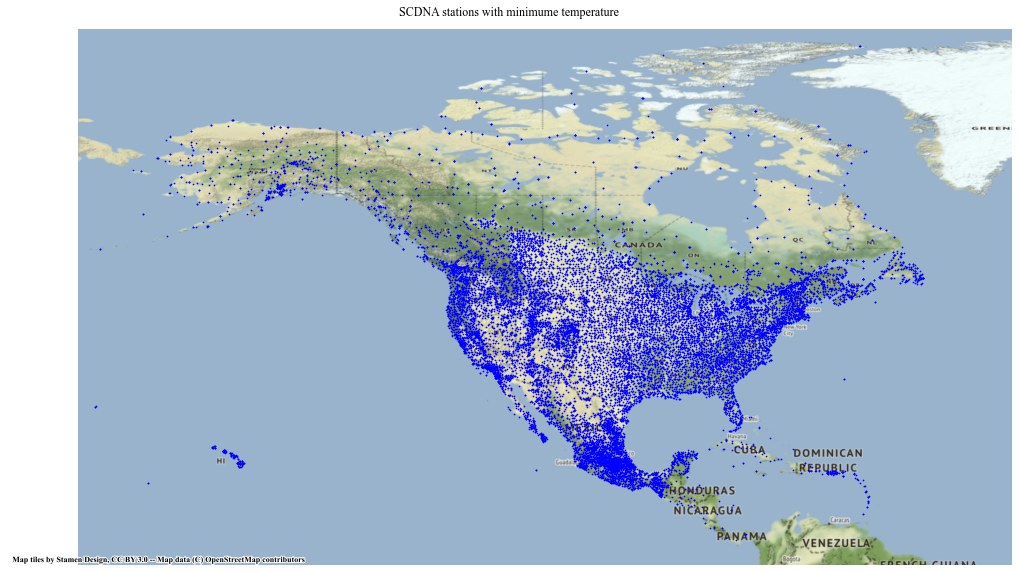

In [1]:
import xarray as xr
import pandas as pd
from   shapely.geometry import Point
import geopandas as gpd
import matplotlib
import os
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)


pwd = '/Users/shg096/Desktop/SCDNA/' # folder where downloaded SCDNA is save should be ending with '/'

infile_prcp  = pwd+'/prcp/SCDNA_v1.1.prcp.1979.nc'
outfile_prcp = pwd+'/prcp/SCDNA.prcp.gpkg'

infile_tmin  = pwd+'/tmin/SCDNA_v1.1.tmin.1979.nc'
outfile_tmin = pwd+'/tmin/SCDNA.tmin.gpkg'

infile_tmax  = pwd+'/tmax/SCDNA_v1.1.tmax.1979.nc'
outfile_tmax = pwd+'/tmax/SCDNA.tmax.gpkg'


def create_shp_SCDNA(infile, outfile):
    
    # load one the yearly nc files
    ds = xr.open_dataset(infile)
    
    nstn = ds.lat.shape[0] # number of stations

    points = pd.DataFrame()
    points['LATITUDE']  = ds.lat[:]
    points['LONGITUDE'] = ds.lon[:]
    points['ID']        = ds.stn[:]

    # the columns of the DataFrame
    points['geometry'] = points.apply(lambda row: Point(row.LONGITUDE, row.LATITUDE ), axis=1) # set the geometry
    points  = gpd.GeoDataFrame(points) # pass this to a geopandas dataframe
    points = points.set_crs("EPSG:4326") # set the projection to WGS 1984
    points.to_file(outfile)
    
create_shp_SCDNA(infile_prcp, outfile_prcp)
create_shp_SCDNA(infile_tmin, outfile_tmin)
create_shp_SCDNA(infile_tmax, outfile_tmax)



## visualizing the point shapefiles for precipitation stations
import contextily as ctx
import matplotlib.pyplot as plt

stations = gpd.read_file(outfile_tmin)

fig, ax = plt.subplots(figsize=(18, 10))
stations.plot(ax=ax, color='blue', markersize = 0.5)
ax.axis('off')
plt.axis('equal')
ctx.add_basemap(ax, zoom=4, crs='EPSG:4326')
#ctx.add_basemap(ax, zoom=4, crs=crs)

plt.title ('SCDNA stations with minimume temperature')
plt.savefig('../fig/Example3_A.png')
plt.show()




<ipython-input-2-89c90057e34d>:28: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations_buffert = stations.buffer(1) # add a buffer of 1 degree to the stations shapefile


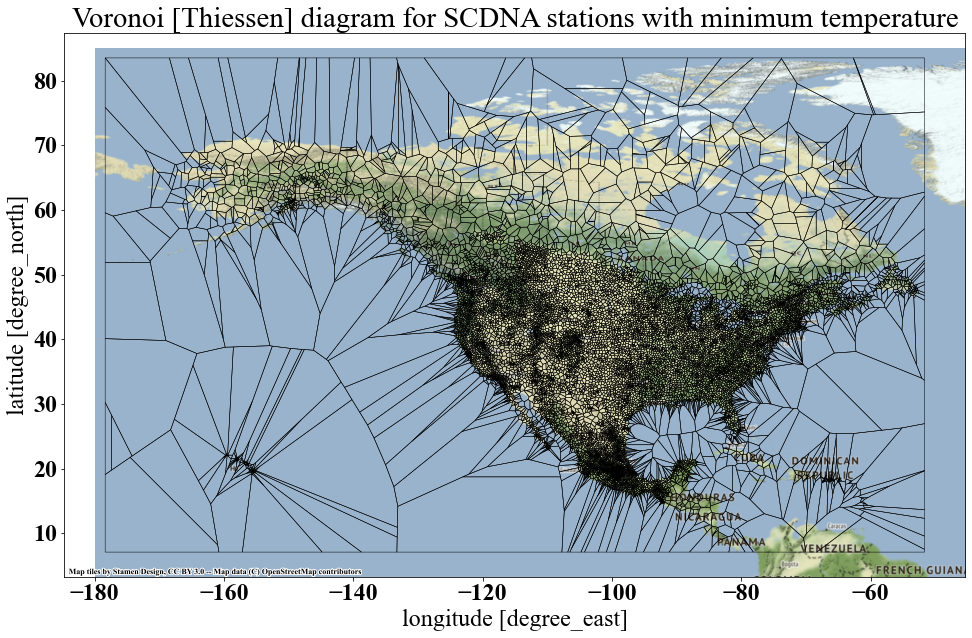

In [2]:
import shapefile
import geovoronoi
import os
from   shapely.geometry import Polygon
import numpy as np
import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)

infile_prcp  = pwd+'/prcp/SCDNA.prcp.gpkg'
outfile_prcp = pwd+'/prcp/SCDNA.prcp.voronoi.gpkg'

infile_tmin  = pwd+'/tmin/SCDNA.tmin.gpkg'
outfile_tmin = pwd+'/tmin/SCDNA.tmin.voronoi.gpkg'

infile_tmax  = pwd+'/tmax/SCDNA.tmax.gpkg'
outfile_tmax = pwd+'/tmax/SCDNA.tmax.voronoi.gpkg'


def voronoi_diagram(infile, outfile): # infile a point shapefile, outfile a shapefile
    
    # read the shapefile
    stations = gpd.read_file(infile)
    
    # get the total boundary of the shapefile
    stations_buffert = stations.buffer(1) # add a buffer of 1 degree to the stations shapefile
    minx, miny, maxx, maxy = stations_buffert.total_bounds
    
    # create the bounding shapefile
    parts = []
    with shapefile.Writer('test.shp') as w:
        w.autoBalance = 1 # turn on function that keeps file stable if number of shapes and records don't line up
        w.field("ID_bounding",'N') # create (N)umerical attribute fields, integer

        # creating the polygon given the lat and lon
        parts.append([ (minx, miny),\
                       (minx, maxy), \
                       (maxx, maxy), \
                       (maxx, miny), \
                       (minx, miny)])

        # store polygon
        w.poly(parts)

        # update records/fields for the polygon
        w.record(1)

    boundary = gpd.read_file('test.shp')
    os.remove('test.dbf');os.remove('test.shx');os.remove('test.shp')
    
    # create the voroni diagram for given point shapefile
    coords = geovoronoi.points_to_coords(stations.geometry)

    poly_shapes, location = \
    geovoronoi.voronoi_regions_from_coords(coords, boundary.iloc[0].geometry)
    
    
    # pass te polygons to shapefile
    Thiessen = gpd.GeoDataFrame()
    Thiessen['geometry'] = None
    Thiessen['ID'] = None
    Thiessen['LATITUDE'] = None
    Thiessen['LONGITUDE'] = None


    for i in np.arange(len(poly_shapes)):
        Thiessen.loc[i, 'geometry'] = Polygon(poly_shapes[i])
        Thiessen.loc[i, 'ID']       = stations.iloc[location[i][0]].ID.astype(float)
        Thiessen.loc[i, 'LATITUDE'] = stations.iloc[location[i][0]].LATITUDE.astype(float)
        Thiessen.loc[i, 'LONGITUDE']= stations.iloc[location[i][0]].LONGITUDE.astype(float)
    
    Thiessen = Thiessen.set_crs("EPSG:4326")

    Thiessen.to_file(outfile)
    
voronoi_diagram(infile_prcp, outfile_prcp)
voronoi_diagram(infile_tmin, outfile_tmin)
voronoi_diagram(infile_tmax, outfile_tmax)

## visualization of voronoi diagram for precipitation stations
shp = gpd.read_file(outfile_tmin)
fig, ax = plt.subplots(figsize=(18, 10))
shp.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0.5 , figsize=(15,30),ax=ax)
ctx.add_basemap(ax, zoom=4, crs='EPSG:4326')
plt.title('Voronoi [Thiessen] diagram for SCDNA stations with minimum temperature')
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.savefig('../fig/Example3_B.png')


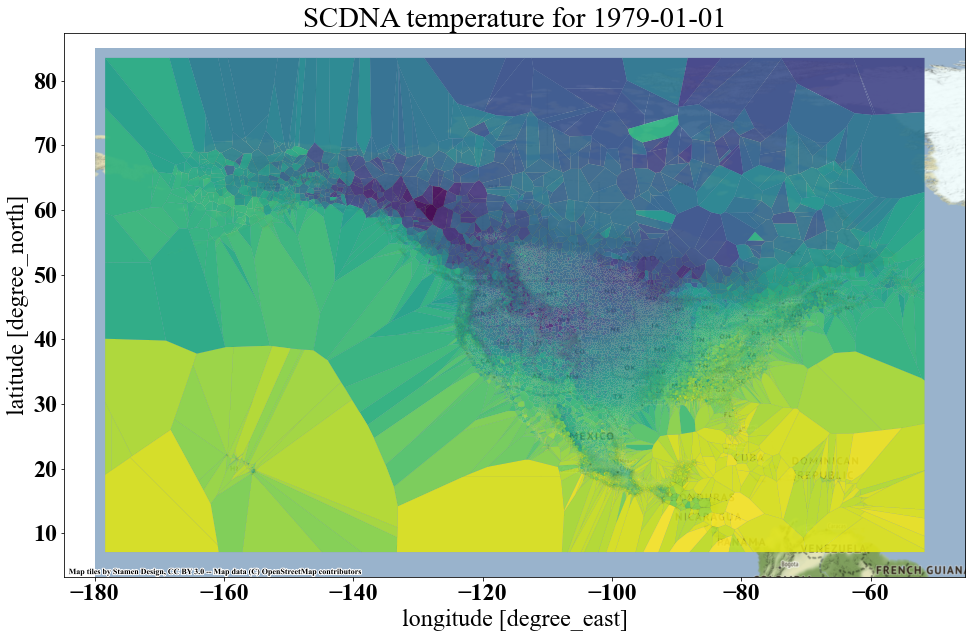

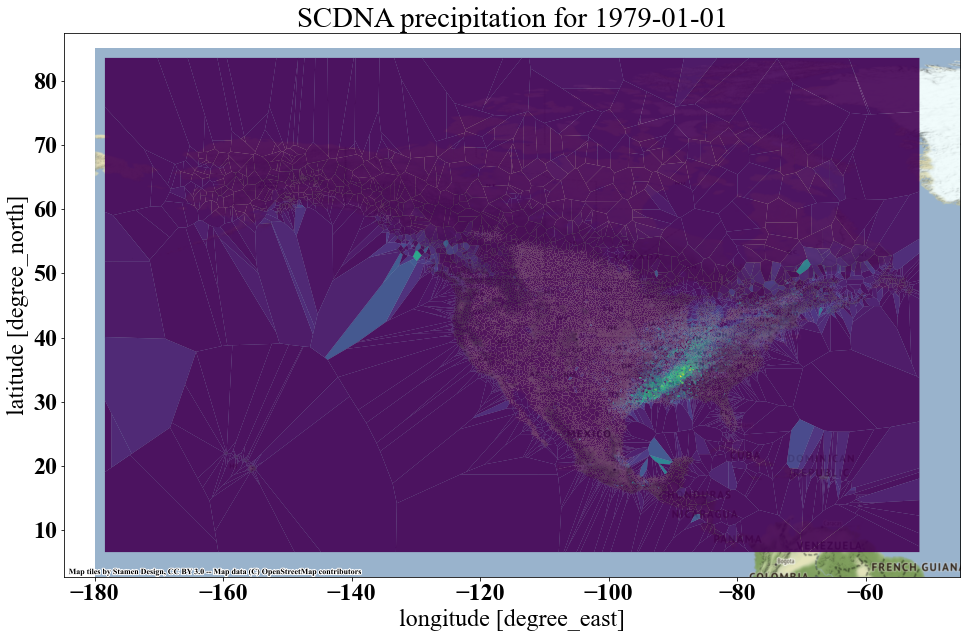

In [3]:
# visualize the voronoi diagram with data from SCDNA

voronoi_prcp = pwd+'/tmin/SCDNA.tmin.voronoi.gpkg'
infile_prcp  = pwd+'/tmin/SCDNA_v1.1.tmin.1979.nc'

#
Thiessen = gpd.read_file(voronoi_prcp)
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')

#
ds = xr.open_dataset(infile_prcp)
df = pd.DataFrame()
df ['values']     = ds.tmin.sel(time='1979-01-01')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)
df = df.sort_values(by='ID')# sort on values

# merge based on ID
Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.title('SCDNA temperature for 1979-01-01')
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.savefig('../fig/Example3_C.png')



# visualize the voronoi diagram with data from SCDNA
voronoi_prcp = pwd+'/prcp/SCDNA.prcp.voronoi.gpkg'
infile_prcp  = pwd+'/prcp/SCDNA_v1.1.prcp.1979.nc'

#
Thiessen = gpd.read_file(voronoi_prcp)
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')

#
ds = xr.open_dataset(infile_prcp)
df = pd.DataFrame()
df ['values']     = ds.prcp.sel(time='1979-01-01')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)
df = df.sort_values(by='ID')# sort on values

# merge based on ID
Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='values', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.title('SCDNA precipitation for 1979-01-01')
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.savefig('../fig/Example3_D.png')


In [1]:
# loading EASYMORE
from easymore.easymore import easymore

# initializing EASYMORE object
esmr = easymore()

# specifying EASYMORE needed arguments
esmr.case_name             = 'SCDNA_Medicine_Hat' # name of the case
esmr.temp_dir              = '../temporary/' # temporary path that the EASYMORE generated GIS files and rempped file will be saved
esmr.target_shp            = '../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp' # target shapefile that the source will be remmaped to
esmr.source_nc             = '/Users/shg096/Desktop/SCDNA/tmin/SCDNA_*.nc' # name of netCDF file(s) if multiple you can specify with *
esmr.var_names             = ['tmin'] # name of variables from source netCDF file(s) to be remapped
esmr.var_lon               = 'lon' # name of varibale longitude in source netCDF files 
esmr.var_lat               = 'lat' # name of variable latitude in source netCDF files
esmr.var_time              = 'time' # name of varibale time in source netCDF file
esmr.source_shp            = '/Users/shg096/Desktop/SCDNA/tmin/SCDNA.tmin.voronoi.gpkg'
esmr.source_shp_lat        =  'LATITUDE' # name_of_nc_files
esmr.source_shp_lon        =  'LONGITUDE'
esmr.output_dir            = '../output/' # location where the remapped netCDF file will be saved
esmr.format_list           =  ['f4'] # format of the varibales to be saved with
esmr.fill_value_list       = ['-9999.00'] # missing values for the varibales
#esmr.remap_csv             = '../temporary/SCDNA_Medicine_Hat_remapping.csv' # if uncommneted EASYMOREcandex will use this and skip GIS taskes

# execute EASYMORE
esmr.nc_remapper()



no author name is provide and the author name is changed to (author name)!
EASYMORE will remap variable  tmin  from source file to variable  tmin  in remapped NeCDF file
EASYMORE detects that target shapefile is in WGS84 (epsg:4326)
EASYMORE detects that no field for ID is provided in sink/target shapefile
arbitarary values of ID are added in the field ID_t
EASYMORE detects that either of the fields for latitude or longitude is not provided in sink/target shapefile
calculating centroid of shapes in equal area projection
point shapefile for centroid of the shapes is saves here:
../temporary/SCDNA_Medicine_Hat_centroid.shp
EASYMORE detects that no field for latitude is provided in sink/target shapefile
latitude values are added in the field lat_t
EASYMORE detects that no field for longitude is provided in sink/target shapefile
longitude values are added in the field lon_t
it seems everything is OK with the sink/target shapefile; added to EASYMORE object target_shp_gpd
EASYMORE will save 

/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/easymore/easymore.py:145: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_int.to_file(self.temp_dir+self.case_name+'_intersected_shapefile.shp') # save the intersected files


------REMAPPING------
Remapping /Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1979.nc to ../output/SCDNA_Medicine_Hat_remapped_1979-01-01-00-00-00.nc
Started at date and time 2021-04-16 17:37:33.291478
Ended   at date and time 2021-04-16 17:37:35.489036
------
Remapping /Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1980.nc to ../output/SCDNA_Medicine_Hat_remapped_1980-01-01-00-00-00.nc
Started at date and time 2021-04-16 17:37:35.498900
Ended   at date and time 2021-04-16 17:37:37.591209
------
Remapping /Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1981.nc to ../output/SCDNA_Medicine_Hat_remapped_1981-01-01-00-00-00.nc
Started at date and time 2021-04-16 17:37:37.600221
Ended   at date and time 2021-04-16 17:37:39.628404
------


/Users/shg096/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


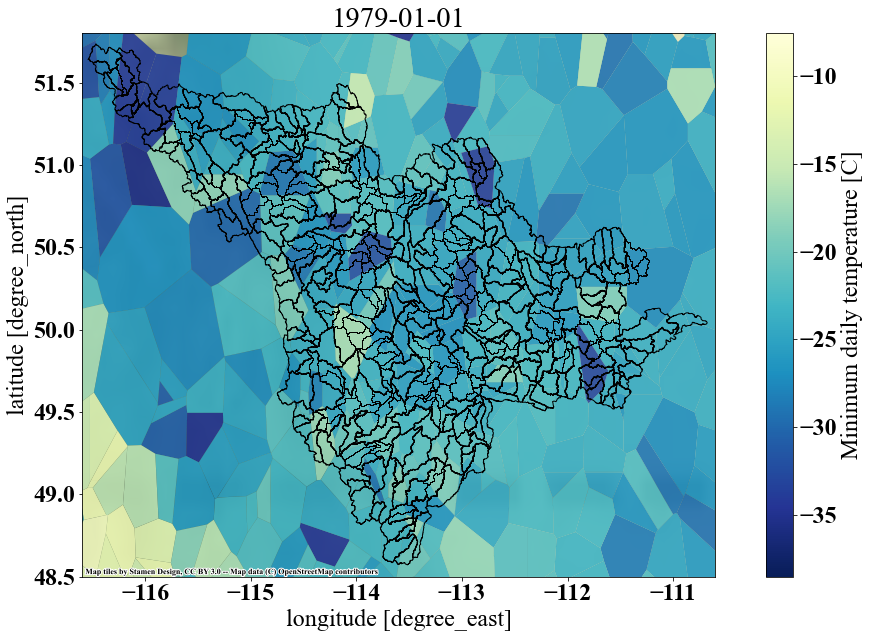

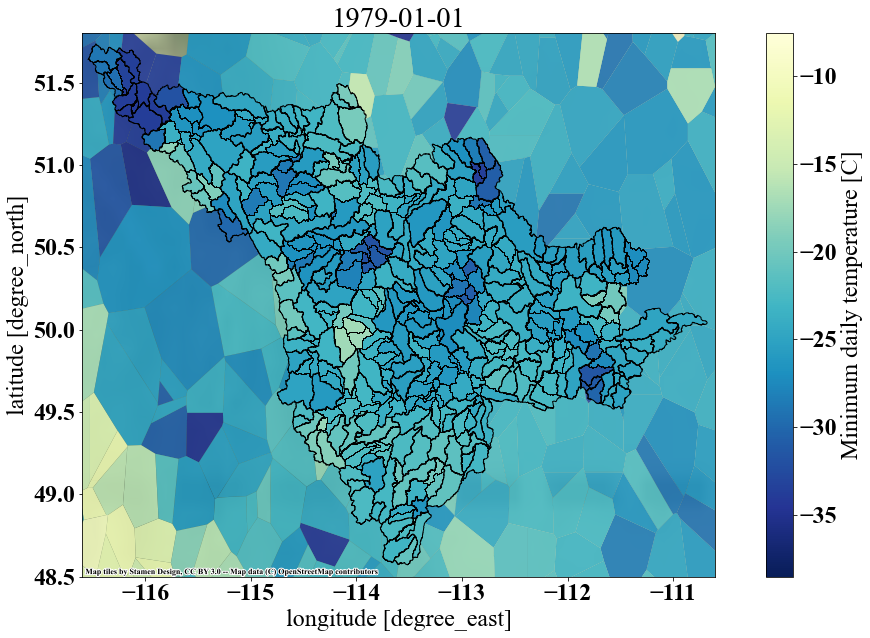

In [3]:
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as colors

import matplotlib
font = {'family' : 'Times New Roman',
         'weight' : 'bold',
         'size'   : 24}
matplotlib.rc('font', **font)

ds = xr.open_dataset('/Users/shg096/Desktop/SCDNA/tmin/SCDNA_v1.1.tmin.1979.nc')
Thiessen = gpd.read_file('/Users/shg096/Desktop/SCDNA/tmin/SCDNA.tmin.voronoi.gpkg')
Thiessen['ID'] = Thiessen['ID'].astype(int)
Thiessen = Thiessen.sort_values(by='ID')
shp_target = gpd.read_file(esmr.temp_dir+ esmr.case_name +\
                           '_target_shapefile.shp') # load the target shapefile
shp_target = shp_target.sort_values(by='ID_t')


#
df = pd.DataFrame()
df ['value']     = ds.tmin.sel(time='1979-01-10')
df ['ID']         = ds.stn[:].astype(int)
df ['lat_nc']     = ds.lat[:].astype(float)
df ['lon_nc']     = ds.lon[:].astype(float)


df = df.dropna() # drop the values that are NaN
df = df.sort_values(by='ID')# sort on values

Thiessen = pd.merge_asof(Thiessen, df, on='ID', direction='nearest')

# subsetting
Thiessen = Thiessen[Thiessen['lat_nc']<52]
Thiessen = Thiessen[Thiessen['lat_nc']>48]
Thiessen = Thiessen[Thiessen['lon_nc']<-110]
Thiessen = Thiessen[Thiessen['lon_nc']>-120]

Thiessen = gpd.GeoDataFrame(Thiessen)

## visualization
norm = colors.Normalize(vmin=Thiessen.value.min(), vmax=Thiessen.value.max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='YlGnBu_r')

fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='value', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax, cmap='YlGnBu_r', legend=False)
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.xlim([-116.6 , -110.6 ])
plt.ylim([48.5 , 51.8 ])
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.title('1979-01-01')
shp_target.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 1 , figsize=(15,30),ax=ax)

# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label('Minimum daily temperature [C]')
plt.savefig('../fig/Example3_E.png')

## visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax1 = Thiessen.plot(column='value', edgecolor='k',linewidth = 0.01 , figsize=(15,30),\
                                alpha=0.9, ax = ax, cmap='YlGnBu_r')
ctx.add_basemap(ax1, zoom=4, crs='EPSG:4326')
plt.xlim([-116.6 , -110.6 ])
plt.ylim([48.5 , 51.8 ])
plt.xlabel('longitude [degree_east]')
plt.ylabel('latitude [degree_north]')
plt.title('1979-01-01')


ds2 = xr.open_dataset('../output/SCDNA_Medicine_Hat_remapped_1979-01-01-00-00-00.nc')

shp_target ['value'] = ds2.tmin.sel(time='1979-01-10')

shp_target.plot(column='value', edgecolor='k',linewidth = 1 , figsize=(15,30),ax=ax,\
                legend=False, cmap='YlGnBu_r',\
                vmin = Thiessen.value.min(), vmax = Thiessen.value.max())

# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
ax_cbar.set_label('Minimum daily temperature [C]')
plt.savefig('../fig/Example3_F.png')
